In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 9.6 MB/s eta 0:00:00


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import pickle
import itertools
from scipy.stats import gaussian_kde, genpareto, norm, t, gennorm, jarque_bera, stats, chi2
from sklearn.metrics import mean_squared_error

from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, acorr_lm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.api import STL, ExponentialSmoothing, STLForecast
from statsmodels.tsa.statespace import exponential_smoothing

In [ ]:
df = pd.read_excel('all_data_shortened.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2854 entries, 0 to 2853
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2854 non-null   datetime64[ns]
 1   LKOH    2854 non-null   float64       
 2   GAZP    2854 non-null   float64       
 3   SBER    2854 non-null   float64       
 4   TATN    2854 non-null   float64       
 5   NVTK    2854 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 133.9 KB


# Анализ исходных данных

Соберем сперва наш индекс, по известным долям

In [ ]:
index_weight = pd.read_excel('my_index_shorted.xlsx')
index_weight.set_index('Тикер', inplace=True)

In [ ]:
real_prices_LKOH = df['LKOH'].values
real_prices_GAZP = df['GAZP'].values
real_prices_SBER = df['SBER'].values
real_prices_TATN = df['TATN'].values
real_prices_NVTK = df['NVTK'].values

portfolio_values_real = index_weight.loc['LKOH', 'Доля'] * real_prices_LKOH + \
                        index_weight.loc['GAZP', 'Доля'] * real_prices_GAZP + \
                        index_weight.loc['SBER', 'Доля'] * real_prices_SBER + \
                        index_weight.loc['TATN', 'Доля'] * real_prices_TATN + \
                        index_weight.loc['NVTK', 'Доля'] * real_prices_NVTK

In [ ]:
df['Index'] = portfolio_values_real

In [ ]:
df.to_excel('df_final_shorted.xlsx', index=False) #Сохранила, чтобы в будущем начинать с данного шаге

Прежде чем перейти к моделированию, рассмотрим предоставленный набор данных. Исходные данные содержат:  

- **Исторические котировки** акций, входящих в индекс IMOEX   
- **Динамику самого индекса Index**

Первичный анализ данных позволяет:  
1. Оценить полноту и качество временных рядов  
2. Проверить наличие пропусков в данных  
3. Убедиться в корректности входных данных

In [ ]:
fig = px.line(
    df,
    x='date',
    y=df.columns.drop('date'),  # Все колонки кроме 'date'
    title='Графики акций MOEX',
    labels={'value': 'Цена', 'variable': 'Акция'},
    template='plotly_white'  # Стиль графика
)

fig.update_layout(
    legend_title_text='Акции',
    hovermode='x unified',  # Показывать значения всех линий при наведении
    xaxis_title='Дата',
    yaxis_title='Цена',
    height=600,
    width=1000
)

fig.show()

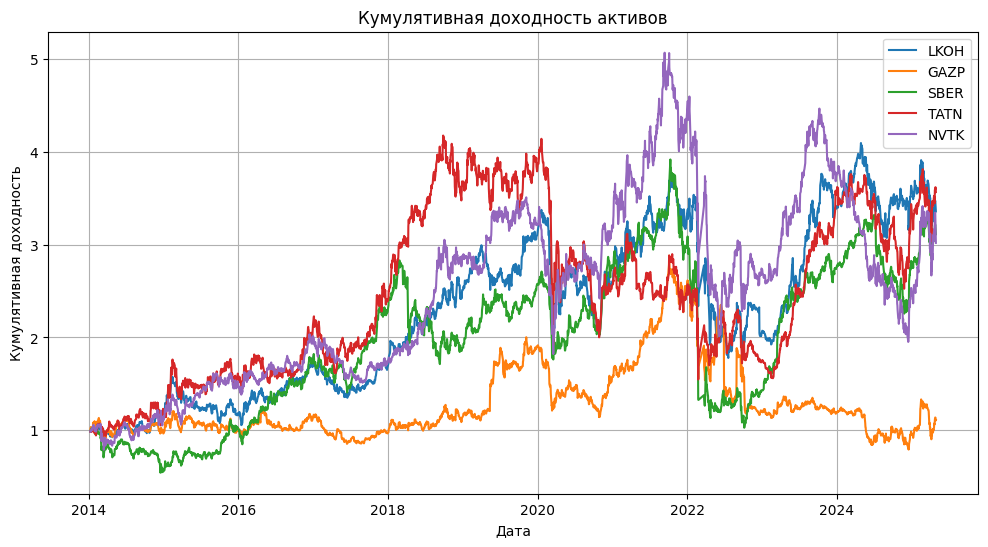

In [ ]:
df_draw = df[['LKOH', 'GAZP', 'SBER', 'TATN', 'NVTK']].copy()

# Рассчитываем кумулятивную доходность (начиная с 1)
cumulative_returns = (1 + df_draw.pct_change()).cumprod()

# Построение графика
plt.figure(figsize=(12, 6))
for column in cumulative_returns.columns:
    plt.plot(df['date'], cumulative_returns[column], label=column)

plt.title('Кумулятивная доходность активов')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная доходность')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
if 'date' in df.columns:
    df = df.set_index('date')

# Рассчитываем логарифмические доходности
log_returns = np.log(df / df.shift(1)).dropna()
log_returns = log_returns.reset_index()

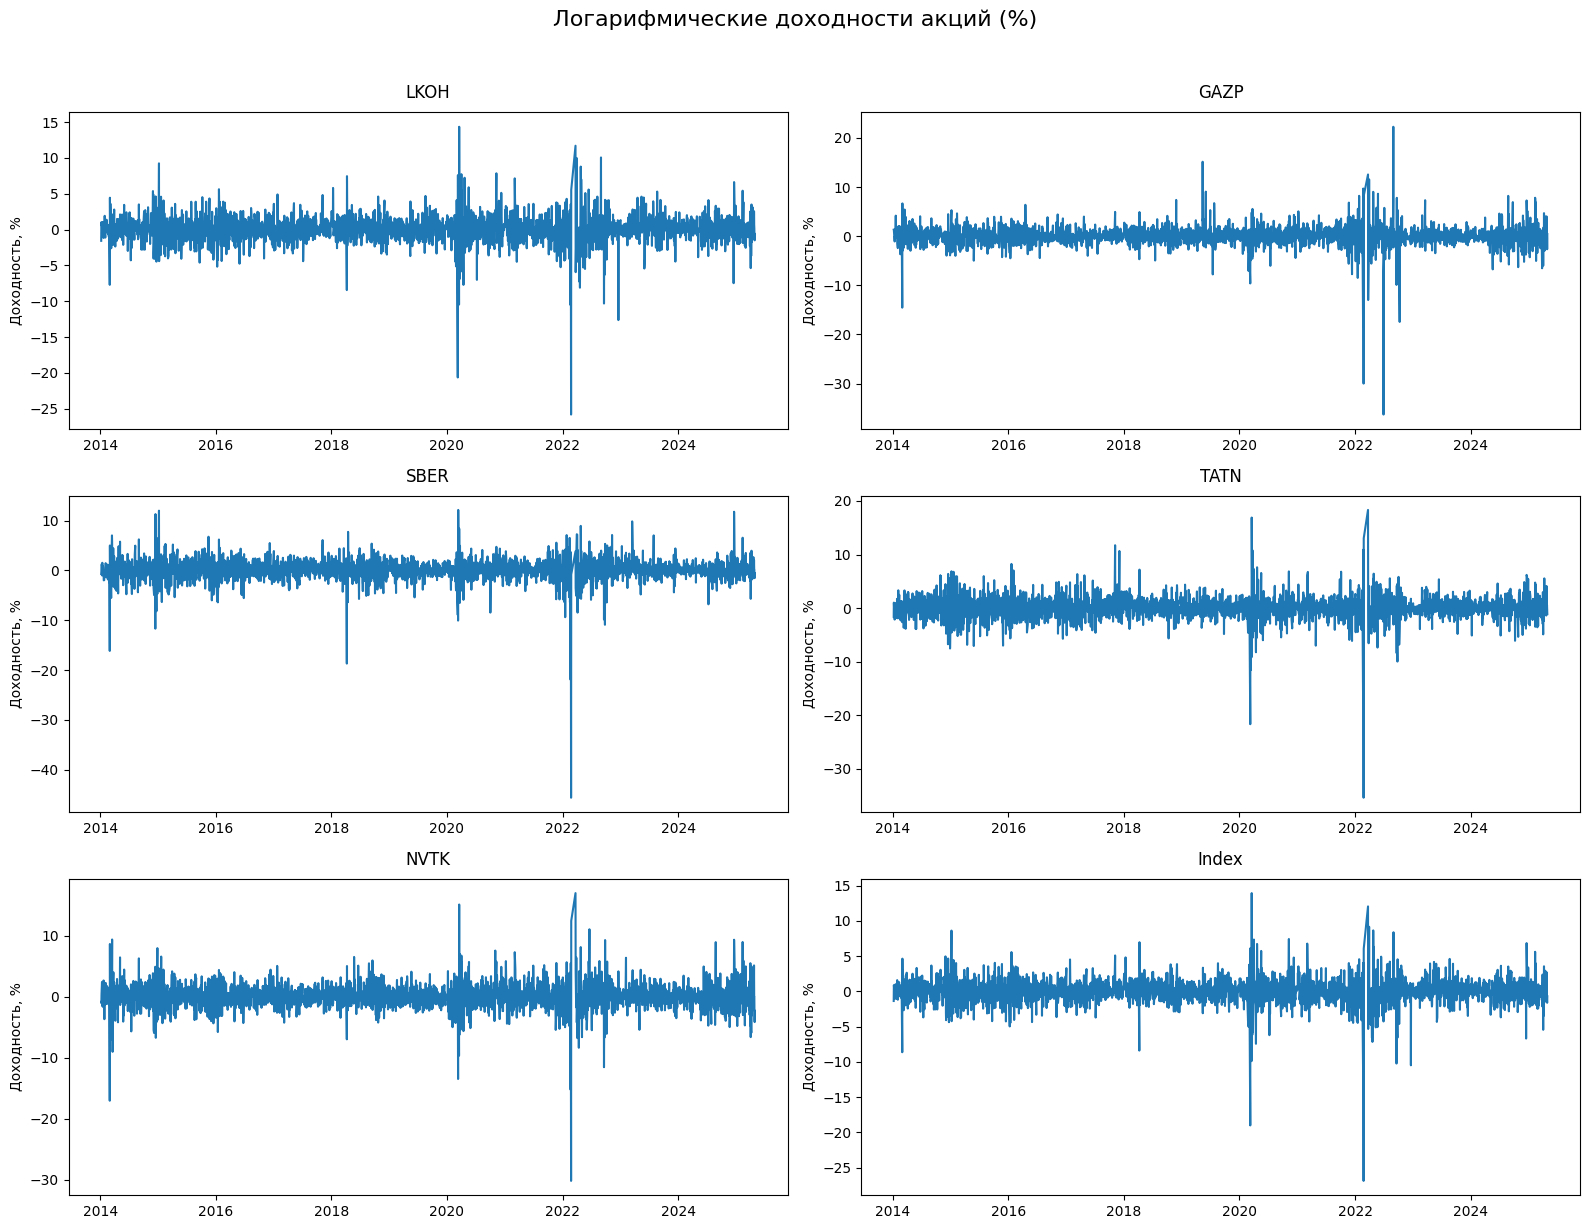

In [ ]:
share_name = ['LKOH', 'GAZP', 'SBER', 'TATN', 'NVTK', 'Index']
num_plots = len(share_name)
num_rows = (num_plots + 1) // 2

plt.figure(figsize=(16, num_rows * 4))
plt.suptitle('Логарифмические доходности акций (%)', y=1.02, fontsize=16)

for i, share in enumerate(share_name, 1):
    plt.subplot(num_rows, 2, i)
    plt.plot(log_returns['date'], log_returns[share]*100)
    plt.title(f"{share}", pad=10, fontsize=12)
    plt.ylabel('Доходность, %', fontsize=10)

plt.tight_layout()
plt.show()

# Описательная статистика данных

In [ ]:
if 'date' in log_returns.columns:
    returns = log_returns.drop(columns=['date'])
else:
    returns = log_returns.copy()

# Функция для расчета всех статистик
def calculate_stats(series):
    statistics = {
        'Среднее': series.mean(),
        'Стандартное отклонение': series.std(),
        'Медиана': series.median(),
        'Минимум': series.min(),
        'Максимум': series.max(),
        'Разброс': series.max() - series.min(),
        'Скошенность': series.skew(),
        'Куртозис': series.kurtosis(),
        'Стандартная ошибка': series.sem(),
    }

    # Рассчитываем тест Харке-Бера (Jarque-Bera)
    jb_stat, jb_pvalue = jarque_bera(series)
    statistics['Статистика Харке-Бера'] = jb_stat
    statistics['P-value (для ст.Харке-Бера)'] = jb_pvalue

    return statistics

In [ ]:
results = pd.DataFrame()

for ticker in returns.columns:
    statistics = calculate_stats(returns[ticker]*100) #статистика описана в процентах
    results[ticker] = pd.Series(statistics)

# Транспонируем и форматируем вывод
results = results.T
pd.options.display.float_format = '{:.2f}'.format

# Выводим результаты
print("Описательная статистика логарифмических доходностей (%):")
display(results)

# Сохраняем в Excel
results.to_excel("акции_статистика.xlsx", float_format="%.2f")

Описательная статистика логарифмических доходностей (%):


,Среднее,Стандартное отклонение,Медиана,Минимум,Максимум,Разброс,Скошенность,Куртозис,Стандартная ошибка,Статистика Харке-Бера,P-value (для ст.Харке-Бера)
LKOH,0.04,1.91,0.04,-25.82,14.34,40.17,-1.22,21.39,0.04,54893.55,0.00
GAZP,0.00,2.15,-0.03,-36.32,22.28,58.60,-2.48,53.06,0.04,336349.47,0.00
SBER,0.04,2.25,0.04,-45.59,12.13,57.72,-3.53,66.60,0.04,531325.39,0.00
TATN,0.04,2.25,0.03,-35.45,18.33,53.77,-1.34,30.25,0.04,109214.00,0.00
NVTK,0.04,2.15,-0.02,-30.17,16.96,47.13,-0.84,20.38,0.04,49515.38,0.00
Index,0.04,1.82,0.05,-26.89,13.96,40.85,-1.45,25.94,0.03,80692.63,0.00


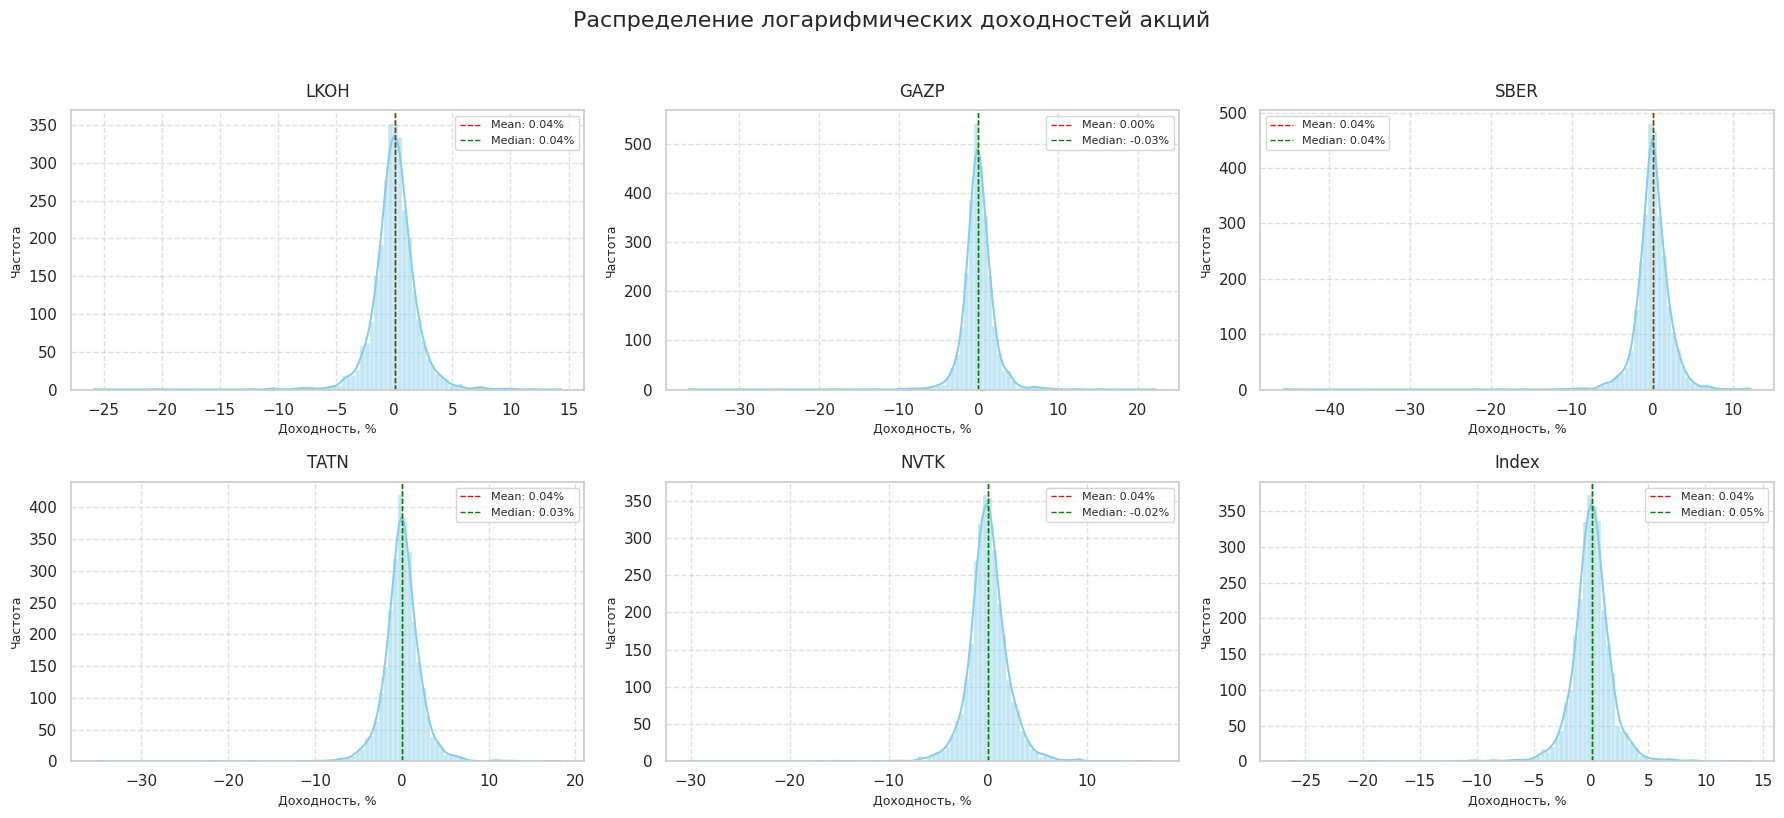

In [ ]:
sns.set_theme(style="whitegrid")

tickers = [col for col in log_returns.columns if col not in ['date']]

num_plots = len(tickers)
num_cols = 3
num_rows = int(np.ceil(num_plots / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows*4))
fig.suptitle('Распределение логарифмических доходностей акций', y=1.02, fontsize=16)

# Проходим по всем акциям и строим распределения
for idx, ticker in enumerate(tickers):
    row = idx // num_cols
    col = idx % num_cols

    # Выбираем ось для текущего графика
    ax = axes[row, col] if num_rows > 1 else axes[col]

    # Строим распределение с KDE
    sns.histplot(data=log_returns[ticker]*100, bins=100, kde=True, ax=ax, color='skyblue')

    # Настройки отображения
    ax.set_title(ticker, fontsize=12, pad=10)
    ax.set_xlabel('Доходность, %', fontsize=9)
    ax.set_ylabel('Частота', fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Добавляем линии для среднего и медианы
    mean_val = log_returns[ticker].mean()*100
    median_val = log_returns[ticker].median()*100
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}%')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Median: {median_val:.2f}%')
    ax.legend(fontsize=8)

# Удаляем пустые графики
for idx in range(len(tickers), num_rows*num_cols):
    row = idx // num_cols
    col = idx % num_cols
    if num_rows > 1:
        fig.delaxes(axes[row, col])
    else:
        fig.delaxes(axes[col])

plt.tight_layout()
plt.show()

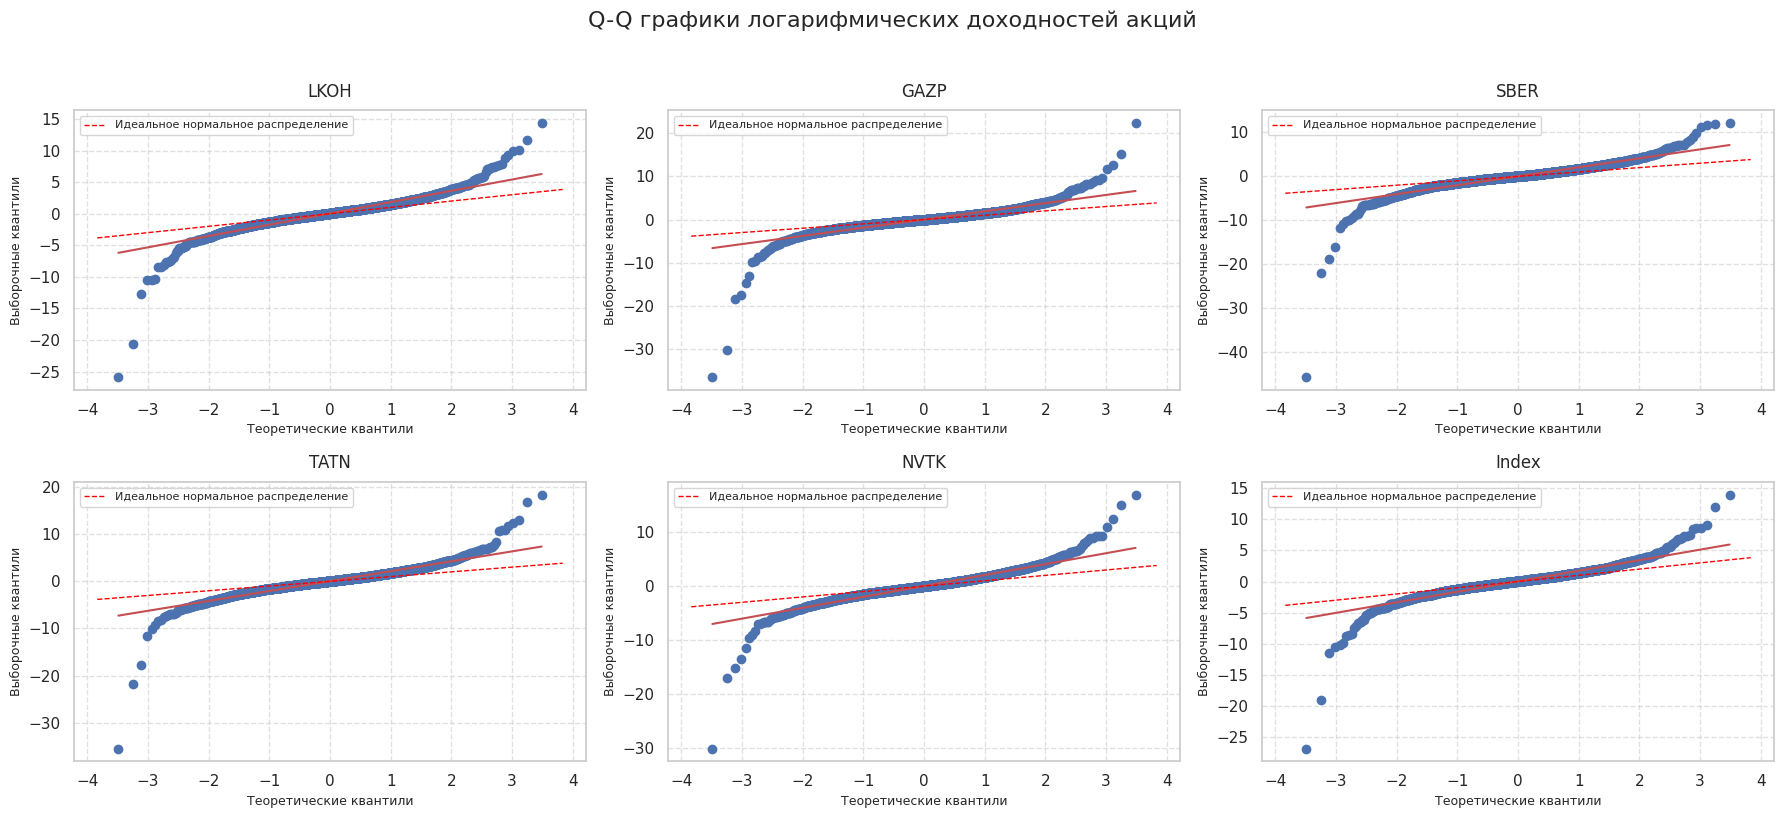

In [ ]:
from scipy.stats import probplot  # Правильный импорт функции
# Инициализация стиля
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'  # Для поддержки кириллицы

# Список акций (исключаем дату и индексы)
tickers = ['LKOH', 'GAZP', 'SBER', 'TATN', 'NVTK', 'Index']

# Настройка сетки графиков
num_cols = 3
num_rows = int(np.ceil(len(tickers) / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows*4))
fig.suptitle('Q-Q графики логарифмических доходностей акций', y=1.02, fontsize=16)

# Построение Q-Q графиков
for idx, ticker in enumerate(tickers):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]

    # Генерация Q-Q plot
    # Извлекаем один столбец и преобразуем в numpy array
    data = log_returns[ticker].values * 100  # Умножаем на 100 для процентного представления

    # Генерация Q-Q plot
    probplot(data, dist="norm", plot=ax)

    # Настройка отображения
    ax.set_title(ticker, fontsize=12, pad=10)
    ax.set_xlabel('Теоретические квантили', fontsize=9)
    ax.set_ylabel('Выборочные квантили', fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Добавляем линию регрессии для визуального сравнения
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, color='red', linestyle='--', linewidth=1, label='Идеальное нормальное распределение')
    ax.legend(fontsize=8)

# Удаление пустых графиков
for idx in range(len(tickers), num_rows*num_cols):
    row = idx // num_cols
    col = idx % num_cols
    if num_rows > 1:
        fig.delaxes(axes[row, col])
    else:
        fig.delaxes(axes[col])

plt.tight_layout()
plt.show()

# Сохранение в файл
fig.savefig('qq_plots.png', dpi=300, bbox_inches='tight', facecolor='white')

**Вывод:**

Статистический анализ показал, что распределение доходностей всех исследуемых акций существенно отклоняется от нормального закона. Это подтверждается следующими ключевыми наблюдениями:
1. **Куртозис** для всех акций значительно превышает 3 (значение для нормального распределения), что указывает на наличие "тяжёлых хвостов" - экстремальные события происходят чаще, чем предполагает нормальное распределение.
2. **Тест Харке-Бера** отвергает гипотезу о нормальности с чрезвычайно высокими значениями статистики (например, 531325.39 для SBER) и ничтожно малыми p-value, что статистически значимо свидетельствует о том, что нормальное распределение отвргается.

**Рекомендации для дальнейшего анализа:**
1. Использовать модели, учитывающие "тяжёлые хвосты":
   - GARCH-модели для волатильности
   - t-распределение Стьюдента вместо нормального

# Моделирование акций

Прежде всего проанализируем ряд на наличие стационарности, используя критерий Дики-Фуллера.  

In [ ]:
# Функция для расчета всех статистик с ADF тестом
def calculate_adf(series):
  statistics = {}
  # Тест Дики-Фуллера (ADF)
  adf_result = adfuller(series)
  statistics['ADF Statistic'] = adf_result[0]
  statistics['ADF p-value'] = adf_result[1]
  statistics['Стационарность (p<0.05)'] = adf_result[1] < 0.05

  return statistics

results_adf = pd.DataFrame()

for ticker in returns.columns:
    statistics = calculate_adf(returns[ticker]*100)  # Анализ в процентах
    results_adf[ticker] = pd.Series(statistics)

# Транспонируем и форматируем
results_adf = results_adf.T
pd.options.display.float_format = '{:.4f}'.format  # Для лучшей читаемости ADF статистики


print("Расширенная статистика логарифмических доходностей:")
display(results_adf)

# Сохраняем в Excel
# results_adf.to_excel("акции_ADF.xlsx", float_format="%.4f")

Расширенная статистика логарифмических доходностей:


,ADF Statistic,ADF p-value,Стационарность (p<0.05)
LKOH,-53.9674,0.0000,True
GAZP,-36.4546,0.0000,True
SBER,-18.6056,0.0000,True
TATN,-55.2730,0.0000,True
NVTK,-24.9902,0.0000,True
Index,-54.1890,0.0000,True


Для всех акций  p-value < 0.05: ряд стационарен → переходим к моделированию

Разделим на обучающую и тестовую выборку данные

In [ ]:
# log_returns.to_excel('log_returns_shorted.xlsx', index=False) #Сохранила, чтобы в будущем начинать с данного шаге
# df.to_excel('df_final_shorted.xlsx', index=False) #Сохранила, чтобы в будущем начинать с данного шаге
log_returns = pd.read_excel('log_returns_shorted.xlsx')
df = pd.read_excel('df_final_shorted.xlsx')

In [ ]:
train_df = log_returns[log_returns['date'] <= '2025-04-01']
test_df = log_returns[log_returns['date'] > '2025-04-01']

In [ ]:
len(train_df)

2826

## Моделирование акций отдельных

In [ ]:
def jb_test(residuals,alpha):
    # --------------------------------------------------
    # 1. Тест Харке-Бера на нормальность
    # --------------------------------------------------
    jb_stat = jarque_bera(residuals)
    print(f"\n1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):")
    print(f"   Статистика = {jb_stat[0]:.3f}, p-value = {jb_stat[1]:.4f}")
    print(f"   Вывод: {'Нормальность не отвергается' if jb_stat[1] > alpha else 'Остатки распределены не по нормальному закону!'}")

def lb_test(residuals, alpha):
    # --------------------------------------------------
    # 2. Тесты на автокорреляцию
    # --------------------------------------------------
    print(f"\n2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:")

    # 2.1. Лиунг-Бокс для остатков
    lb_df = acorr_ljungbox(residuals, lags=10, return_df=True)
    significant_lags = lb_df[lb_df.lb_pvalue < alpha].index.tolist()
    print(f"\n2.1. Лиунг-Бокс (остатки):")
    for lag in lb_df.index:
        print(f"   Лаг {lag:2d}: p-value = {lb_df.loc[lag, 'lb_pvalue']:.4f}",
              "*" if lb_df.loc[lag, 'lb_pvalue'] < alpha else "")
    print(f"Вывод: {'Автокорреляция отсутствует' if not significant_lags else 'Обнаружена автокорреляция!'}")

def lb_test_squared(residuals, alpha):
    print(f"\nТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:")
    print(f"\nЛиунг-Бокс (квадраты остатков):")
    # 2.2. Лиунг-Бокс для квадратов остатков (ARCH-эффекты)
    lb_test_squared = acorr_ljungbox(residuals**2, lags=10, return_df=True)
    # Проверяем p-values
    if (lb_test_squared['lb_pvalue'] < alpha).any():
        print("\nЕсть ARCH-эффекты (отвергаем H₀ → нужна GARCH-модель)")
    else:
        print("\nARCH-эффекты отсутствуют (не отвергаем H₀)")

def arch_test(residuals, alpha):
  print(f"\nТест Энгла (ARCH-LM):")
  # 3.1. Тест Энгла (ARCH-LM)
  arch_stat = het_arch(residuals)
  if arch_stat[1] < alpha:
      print("\nТест Энгла: Есть ARCH-эффекты (отвергаем H₀)")
  else:
      print("\nТест Энгла: Нет ARCH-эффектов (не отвергаем H₀)")


def mcleod_li_test(residuals, alpha):
  print(f"\nТест МакЛеода-Ли (McLeod-Li):")
  squared_residuals = residuals ** 2
  # Тест МакЛеода-Ли (аналогичен acorr_lm, но для квадратов)
  test_result = acorr_lm(squared_residuals, nlags=10)  # nlags = число лагов
  print(f"LM Statistic: {test_result[0]}, p-value: {test_result[1]}")
  print(f"   Вывод: {'GARCH-эффекты отсутствуют' if test_result[1] > alpha else 'Обнаружены GARCH-эффекты!'}")

In [ ]:
train_df.columns

Index(['date', 'LKOH', 'GAZP', 'SBER', 'TATN', 'NVTK', 'Index'], dtype='object')

### Анализ акции LKOH

In [ ]:
data = train_df['LKOH']*100

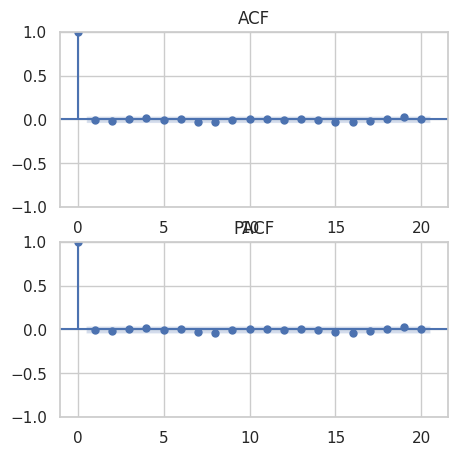

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
plot_acf(data, lags=20, ax=ax1, title='ACF')
plot_pacf(data, lags=20, ax=ax2, title='PACF')
plt.show()

Анализ автокорреляционной (ACF) и частной автокорреляционной (PACF) функций показывает, что ряд доходностей не содержит статистически значимых лаговых зависимостей, что характерно для процесса, близкого к белому шуму. В связи с этим, а также на основании минимизации информационного критерия BIC, в качестве наилучшей спецификации модели выбрана ARMA(0,0).

In [ ]:
model_arma = ARIMA(data, order=(0, 0, 0))
results_arma = model_arma.fit()

# Остатки модели
residuals = results_arma.resid.dropna()

In [ ]:
alpha = 0.05
jb_test(residuals,alpha)
lb_test(residuals, alpha)
lb_test_squared(residuals, alpha)
arch_test(residuals, alpha)
mcleod_li_test(residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 55495.323, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.5861 
   Лаг  2: p-value = 0.4400 
   Лаг  3: p-value = 0.6495 
   Лаг  4: p-value = 0.7394 
   Лаг  5: p-value = 0.8424 
   Лаг  6: p-value = 0.9129 
   Лаг  7: p-value = 0.7344 
   Лаг  8: p-value = 0.4199 
   Лаг  9: p-value = 0.4958 
   Лаг 10: p-value = 0.5878 
Вывод: Автокорреляция отсутствует

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

Есть ARCH-эффекты (отвергаем H₀ → нужна GARCH-модель)

Тест Энгла (ARCH-LM):

Тест Энгла: Есть ARCH-эффекты (отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 314.03226059553873, p-value: 1.6728643343557825e-61
   Вывод: Обнаружены GARCH-эффекты!


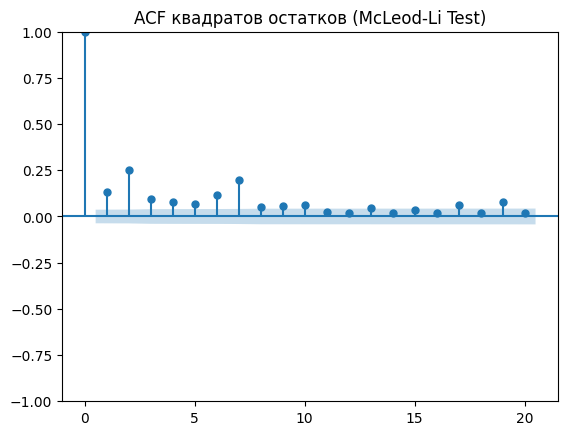

In [ ]:
lags = 20  # Число лагов для анализа
acf_squared = acf(residuals**2, nlags=lags, fft=False)

# Визуализация ACF
plot_acf(residuals**2, lags=lags, alpha=0.05, title='ACF квадратов остатков (McLeod-Li Test)')
plt.show()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 37509.469523227766
Iteration:      2,   Func. Count:     16,   Neg. LLF: 9124.513810247754
Iteration:      3,   Func. Count:     23,   Neg. LLF: 5664.515157439497
Iteration:      4,   Func. Count:     30,   Neg. LLF: 85962.85257761963
Iteration:      5,   Func. Count:     37,   Neg. LLF: 5334.6996670684
Iteration:      6,   Func. Count:     44,   Neg. LLF: 84204.88909699512
Iteration:      7,   Func. Count:     51,   Neg. LLF: 5309.505348811939
Iteration:      8,   Func. Count:     58,   Neg. LLF: 78062.80445475735
Iteration:      9,   Func. Count:     65,   Neg. LLF: 5281.775414310803
Iteration:     10,   Func. Count:     72,   Neg. LLF: 5271.8534014174165
Iteration:     11,   Func. Count:     79,   Neg. LLF: 5271.725042290526
Iteration:     12,   Func. Count:     86,   Neg. LLF: 5271.713485668467
Iteration:     13,   Func. Count:     92,   Neg. LLF: 5271.713478537318
Iteration:     14,   Func. Count:     97,   Neg. LLF: 5271.71347

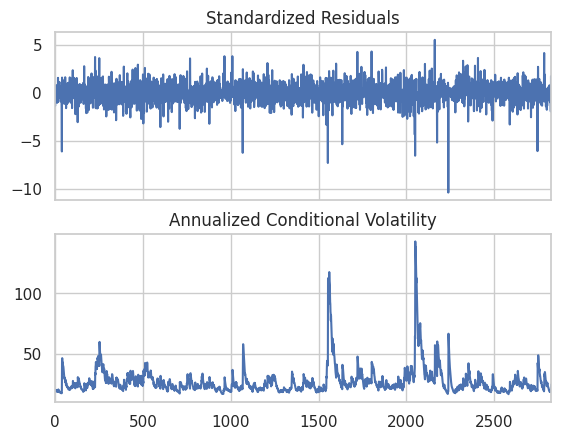

In [ ]:
model_garch = arch_model(data, vol="GARCH", p=1, q=1, dist="t")
results_garch = model_garch.fit()

# Вывод результатов GARCH
print(results_garch.summary())

# Визуализация волатильности
results_garch.plot(annualize='D')  # Ежедневная волатильность
plt.show()

In [ ]:
std_residuals = results_garch.resid / results_garch.conditional_volatility
std_residuals = std_residuals.dropna()

jb_test(std_residuals,alpha)
lb_test(std_residuals, alpha)
lb_test_squared(std_residuals, alpha)
arch_test(std_residuals, alpha)
mcleod_li_test(std_residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 11904.813, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.3403 
   Лаг  2: p-value = 0.4516 
   Лаг  3: p-value = 0.6569 
   Лаг  4: p-value = 0.7873 
   Лаг  5: p-value = 0.8331 
   Лаг  6: p-value = 0.8930 
   Лаг  7: p-value = 0.9219 
   Лаг  8: p-value = 0.8714 
   Лаг  9: p-value = 0.8852 
   Лаг 10: p-value = 0.9277 
Вывод: Автокорреляция отсутствует

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

ARCH-эффекты отсутствуют (не отвергаем H₀)

Тест Энгла (ARCH-LM):

Тест Энгла: Нет ARCH-эффектов (не отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 4.491084094478176, p-value: 0.922486777417092
   Вывод: GARCH-эффекты отсутствуют


Итого для LKOH - ARMA(0,0)-EGARCH(1,1)

### Анализ акции GAZP

In [ ]:
data = train_df['GAZP']*100

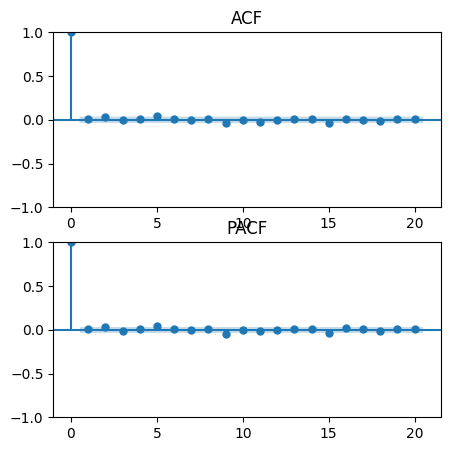

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
plot_acf(data, lags=20, ax=ax1, title='ACF')
plot_pacf(data, lags=20, ax=ax2, title='PACF')
plt.show()

In [ ]:
# Определяем диапазон p и q (p + q ≤ 5)
p_range = range(0, 6)  # от AR(0) до AR(5)
q_range = range(0, 6)  # от MA(0) до MA(5)

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

for p, q in itertools.product(p_range, q_range):
    if p + q > 5:  # пропускаем, если p + q > 5
        continue

    try:
        model = ARIMA(data, order=(p, 0, q))  # ARMA(p, q) = ARIMA(p, 0, q)
        results = model.fit()

        print(f"ARMA({p},{q}): AIC={results.aic:.2f}, BIC={results.bic:.2f}")

        # Сравниваем AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_model_aic = (p, q)

        # Сравниваем BIC
        if results.bic < best_bic:
            best_bic = results.bic
            best_model_bic = (p, q)

    except Exception as e:
        print(f"ARMA({p},{q}) не сошлась: {e}")
        continue

print("\nЛучшая модель по AIC:", f"ARMA{best_model_aic}")
print("Лучшая модель по BIC:", f"ARMA{best_model_bic}")

ARMA(0,0): AIC=12322.27, BIC=12334.17
ARMA(0,1): AIC=12323.77, BIC=12341.61
ARMA(0,2): AIC=12323.61, BIC=12347.40
ARMA(0,3): AIC=12325.32, BIC=12355.05
ARMA(0,4): AIC=12326.92, BIC=12362.60
ARMA(0,5): AIC=12323.92, BIC=12365.55
ARMA(1,0): AIC=12323.74, BIC=12341.58
ARMA(1,1): AIC=12323.80, BIC=12347.58
ARMA(1,2): AIC=12325.33, BIC=12355.06
ARMA(1,3): AIC=12327.61, BIC=12363.28
ARMA(1,4): AIC=12326.61, BIC=12368.24
ARMA(2,0): AIC=12323.60, BIC=12347.38
ARMA(2,1): AIC=12325.38, BIC=12355.11
ARMA(2,2): AIC=12326.94, BIC=12362.62
ARMA(2,3): AIC=12328.76, BIC=12370.38
ARMA(3,0): AIC=12325.40, BIC=12355.13
ARMA(3,1): AIC=12327.35, BIC=12363.03


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3,2): AIC=12314.27, BIC=12355.90
ARMA(4,0): AIC=12326.93, BIC=12362.61
ARMA(4,1): AIC=12326.93, BIC=12368.56
ARMA(5,0): AIC=12324.14, BIC=12365.77

Лучшая модель по AIC: ARMA(3, 2)
Лучшая модель по BIC: ARMA(0, 0)


Анализ автокорреляционной (ACF) и частной автокорреляционной (PACF) функций показывает, что ряд доходностей не содержит статистически значимых лаговых зависимостей, что характерно для процесса, близкого к белому шуму. В связи с этим, а также на основании минимизации информационного критерия BIC, в качестве наилучшей спецификации модели выбрана ARMA(0,0).

In [ ]:
model_arma = ARIMA(data, order=(0, 0, 0))
results_arma = model_arma.fit()

# Остатки модели
residuals = results_arma.resid.dropna()

In [ ]:
alpha = 0.05
jb_test(residuals,alpha)
lb_test(residuals, alpha)
lb_test_squared(residuals, alpha)
arch_test(residuals, alpha)
mcleod_li_test(residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 346421.890, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.4666 
   Лаг  2: p-value = 0.2587 
   Лаг  3: p-value = 0.4124 
   Лаг  4: p-value = 0.4970 
   Лаг  5: p-value = 0.1504 
   Лаг  6: p-value = 0.2147 
   Лаг  7: p-value = 0.3033 
   Лаг  8: p-value = 0.3956 
   Лаг  9: p-value = 0.1496 
   Лаг 10: p-value = 0.2014 
Вывод: Автокорреляция отсутствует

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

Есть ARCH-эффекты (отвергаем H₀ → нужна GARCH-модель)

Тест Энгла (ARCH-LM):

Тест Энгла: Есть ARCH-эффекты (отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 99.33253611594645, p-value: 7.411726770504963e-17
   Вывод: Обнаружены GARCH-эффекты!


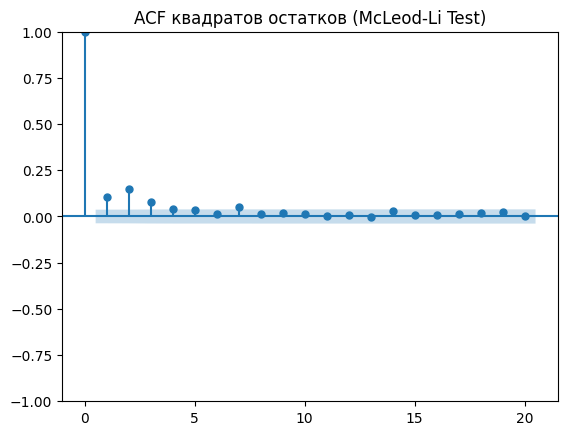

In [ ]:
lags = 20  # Число лагов для анализа
acf_squared = acf(residuals**2, nlags=lags, fft=False)

# Визуализация ACF
plot_acf(residuals**2, lags=lags, alpha=0.05, title='ACF квадратов остатков (McLeod-Li Test)')
plt.show()

In [ ]:
# Перебираем разные p и q
results = []
for p in [1, 2]:
    for q in [0,1, 2]:
        model = arch_model(residuals, vol="EGARCH", p=p, q=q, dist="t") #ged - 10608.039433, t-10552.818142
        res = model.fit(disp="off")
        results.append({
            "p": p,
            "q": q,
            "AIC": res.aic,
            "BIC": res.bic,
            "Log-Likelihood": res.loglikelihood,
        })

# Выводим таблицу сравнения
print(pd.DataFrame(results).sort_values("AIC"))

   p  q           AIC           BIC  Log-Likelihood
4  2  1  10564.103724  10599.783430    -5276.051862
5  2  2  10566.103724  10607.730047    -5276.051862
2  1  2  10569.342439  10605.022144    -5278.671219
1  1  1  10578.330366  10608.063454    -5284.165183
3  2  0  10732.968424  10762.701512    -5361.484212
0  1  0  10761.268438  10785.054908    -5376.634219


Iteration:      1,   Func. Count:      8,   Neg. LLF: 37877.46745366033
Iteration:      2,   Func. Count:     22,   Neg. LLF: 66647.69998085429
Iteration:      3,   Func. Count:     33,   Neg. LLF: 48695.421736993565
Iteration:      4,   Func. Count:     43,   Neg. LLF: 54016.4235812096
Iteration:      5,   Func. Count:     54,   Neg. LLF: 8656.483092949053
Iteration:      6,   Func. Count:     64,   Neg. LLF: 7094.615510172066
Iteration:      7,   Func. Count:     72,   Neg. LLF: 5324.493888211242
Iteration:      8,   Func. Count:     80,   Neg. LLF: 5276.098654284079
Iteration:      9,   Func. Count:     87,   Neg. LLF: 5276.056151080067
Iteration:     10,   Func. Count:     94,   Neg. LLF: 5276.0522348679715
Iteration:     11,   Func. Count:    101,   Neg. LLF: 5276.051870249565
Iteration:     12,   Func. Count:    108,   Neg. LLF: 5276.051992315579
Iteration:     13,   Func. Count:    119,   Neg. LLF: 5276.0518620677
Iteration:     14,   Func. Count:    125,   Neg. LLF: 5276.051862

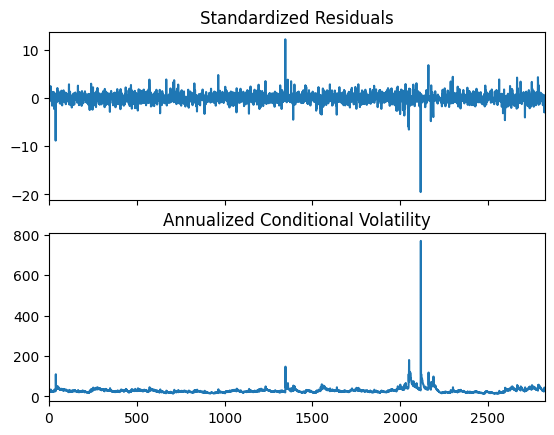

In [ ]:
model_garch = arch_model(residuals, vol="EGARCH", p=2, q=1, dist="t")
results_garch = model_garch.fit()

# Вывод результатов GARCH
print(results_garch.summary())

# Визуализация волатильности
results_garch.plot(annualize='D')  # Ежедневная волатильность
plt.show()

In [ ]:
std_residuals = results_garch.resid / results_garch.conditional_volatility
std_residuals = std_residuals.dropna()

jb_test(std_residuals,alpha)
lb_test(std_residuals, alpha)
lb_test_squared(std_residuals, alpha)
arch_test(std_residuals, alpha)
mcleod_li_test(std_residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 286752.877, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.0113 *
   Лаг  2: p-value = 0.0165 *
   Лаг  3: p-value = 0.0359 *
   Лаг  4: p-value = 0.0135 *
   Лаг  5: p-value = 0.0184 *
   Лаг  6: p-value = 0.0329 *
   Лаг  7: p-value = 0.0521 
   Лаг  8: p-value = 0.0830 
   Лаг  9: p-value = 0.0755 
   Лаг 10: p-value = 0.0928 
Вывод: Обнаружена автокорреляция!

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

ARCH-эффекты отсутствуют (не отвергаем H₀)

Тест Энгла (ARCH-LM):

Тест Энгла: Нет ARCH-эффектов (не отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 0.4222382454728404, p-value: 0.9999970674571805
   Вывод: GARCH-эффекты отсутствуют


На 1% значимости автокорряции нет

Итого для GAZP - ARMA(0,0)-EGARCH(2,1)

### Анализ акции SBER

In [ ]:
data = train_df['SBER']*100

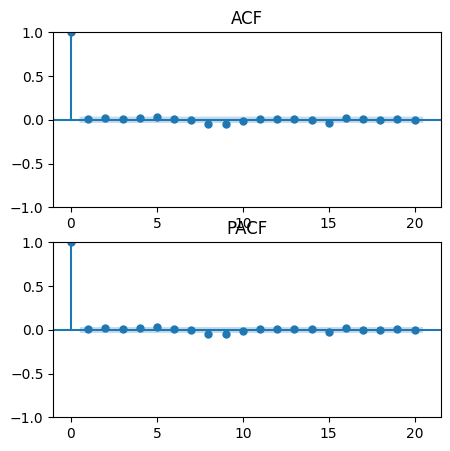

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
plot_acf(data, lags=20, ax=ax1, title='ACF')
plot_pacf(data, lags=20, ax=ax2, title='PACF')
plt.show()

In [ ]:
# Определяем диапазон p и q (p + q ≤ 5)
p_range = range(0, 6)  # от AR(0) до AR(5)
q_range = range(0, 6)  # от MA(0) до MA(5)

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

for p, q in itertools.product(p_range, q_range):
    if p + q > 5:  # пропускаем, если p + q > 5
        continue

    try:
        model = ARIMA(data, order=(p, 0, q))  # ARMA(p, q) = ARIMA(p, 0, q)
        results = model.fit()

        print(f"ARMA({p},{q}): AIC={results.aic:.2f}, BIC={results.bic:.2f}")

        # Сравниваем AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_model_aic = (p, q)

        # Сравниваем BIC
        if results.bic < best_bic:
            best_bic = results.bic
            best_model_bic = (p, q)

    except Exception as e:
        print(f"ARMA({p},{q}) не сошлась: {e}")
        continue

print("\nЛучшая модель по AIC:", f"ARMA{best_model_aic}")
print("Лучшая модель по BIC:", f"ARMA{best_model_bic}")

ARMA(0,0): AIC=12620.51, BIC=12632.40
ARMA(0,1): AIC=12622.35, BIC=12640.19
ARMA(0,2): AIC=12623.55, BIC=12647.34
ARMA(0,3): AIC=12625.44, BIC=12655.17
ARMA(0,4): AIC=12625.70, BIC=12661.38
ARMA(0,5): AIC=12623.45, BIC=12665.07
ARMA(1,0): AIC=12622.35, BIC=12640.19
ARMA(1,1): AIC=12622.78, BIC=12646.57


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(1,2): AIC=12624.04, BIC=12653.78
ARMA(1,3): AIC=12625.74, BIC=12661.42
ARMA(1,4): AIC=12625.33, BIC=12666.95
ARMA(2,0): AIC=12623.50, BIC=12647.29
ARMA(2,1): AIC=12624.06, BIC=12653.80


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(2,2): AIC=12614.80, BIC=12650.48
ARMA(2,3): AIC=12616.87, BIC=12658.49
ARMA(3,0): AIC=12625.34, BIC=12655.07
ARMA(3,1): AIC=12625.85, BIC=12661.53


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3,2): AIC=12628.06, BIC=12669.68
ARMA(4,0): AIC=12625.70, BIC=12661.38
ARMA(4,1): AIC=12626.02, BIC=12667.65
ARMA(5,0): AIC=12624.33, BIC=12665.96

Лучшая модель по AIC: ARMA(2, 2)
Лучшая модель по BIC: ARMA(0, 0)


Анализ автокорреляционной (ACF) и частной автокорреляционной (PACF) функций показывает, что ряд доходностей не содержит статистически значимых лаговых зависимостей, что характерно для процесса, близкого к белому шуму. В связи с этим, а также на основании минимизации информационного критерия BIC, в качестве наилучшей спецификации модели выбрана ARMA(0,0).

In [ ]:
model_arma = ARIMA(data, order=(4, 0, 0))
results_arma = model_arma.fit()

# Остатки модели
residuals = results_arma.resid.dropna()

In [ ]:
alpha = 0.05
jb_test(residuals,alpha)
lb_test(residuals, alpha)
lb_test_squared(residuals, alpha)
arch_test(residuals, alpha)
mcleod_li_test(residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 490817.509, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.9647 
   Лаг  2: p-value = 0.9988 
   Лаг  3: p-value = 0.9999 
   Лаг  4: p-value = 1.0000 
   Лаг  5: p-value = 0.5968 
   Лаг  6: p-value = 0.6938 
   Лаг  7: p-value = 0.7917 
   Лаг  8: p-value = 0.2962 
   Лаг  9: p-value = 0.0505 
   Лаг 10: p-value = 0.0725 
Вывод: Автокорреляция отсутствует

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

Есть ARCH-эффекты (отвергаем H₀ → нужна GARCH-модель)

Тест Энгла (ARCH-LM):

Тест Энгла: Есть ARCH-эффекты (отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 154.79920813140242, p-value: 3.830489987635919e-28
   Вывод: Обнаружены GARCH-эффекты!


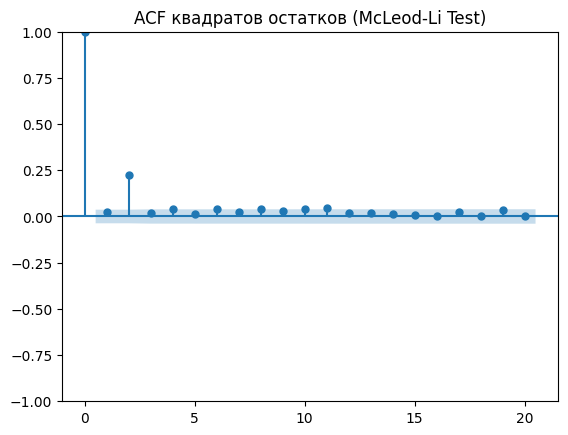

In [ ]:
lags = 20  # Число лагов для анализа
acf_squared = acf(residuals**2, nlags=lags, fft=False)

# Визуализация ACF
plot_acf(residuals**2, lags=lags, alpha=0.05, title='ACF квадратов остатков (McLeod-Li Test)')
plt.show()

In [ ]:
# Перебираем разные p и q
results = []
for p in [1, 2]:
    for q in [0,1, 2]:
        model = arch_model(residuals, vol="EGARCH", p=p, q=q, dist="t") #ged - 10608.039433, t-10552.818142
        res = model.fit(disp="off")
        results.append({
            "p": p,
            "q": q,
            "AIC": res.aic,
            "BIC": res.bic,
            "Log-Likelihood": res.loglikelihood,
        })

# Выводим таблицу сравнения
print(pd.DataFrame(results).sort_values("AIC"))

   p  q           AIC           BIC  Log-Likelihood
4  2  1  11144.048619  11179.728324    -5566.024310
1  1  1  11144.443362  11174.176450    -5567.221681
2  1  2  11144.646924  11180.326629    -5566.323462
5  2  2  11146.048619  11187.674942    -5566.024310
3  2  0  11367.055015  11396.788103    -5678.527508
0  1  0  11430.532310  11454.318780    -5711.266155


Iteration:      1,   Func. Count:      7,   Neg. LLF: 23400.62999755849
Iteration:      2,   Func. Count:     17,   Neg. LLF: 44660.14091815073
Iteration:      3,   Func. Count:     27,   Neg. LLF: 81905.50527544678
Iteration:      4,   Func. Count:     37,   Neg. LLF: 6642.539083045629
Iteration:      5,   Func. Count:     46,   Neg. LLF: 7553.960219462559
Iteration:      6,   Func. Count:     53,   Neg. LLF: 5569.757206108112
Iteration:      7,   Func. Count:     60,   Neg. LLF: 5567.222806801778
Iteration:      8,   Func. Count:     66,   Neg. LLF: 5567.221745357994
Iteration:      9,   Func. Count:     72,   Neg. LLF: 5567.221684372131
Iteration:     10,   Func. Count:     78,   Neg. LLF: 5567.221681139485
Iteration:     11,   Func. Count:     83,   Neg. LLF: 5567.221681139503
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5567.221681139485
            Iterations: 11
            Function evaluations: 83
            Gradient evaluations: 11

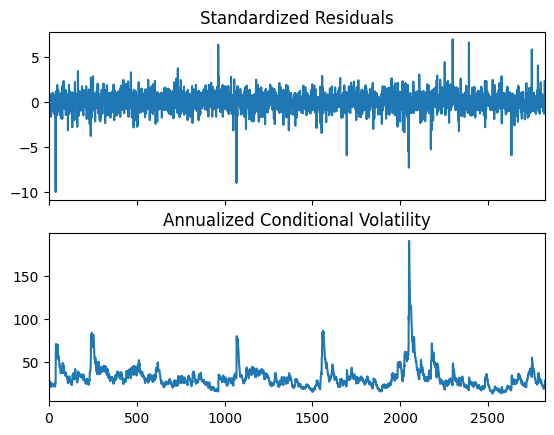

In [ ]:
model_garch = arch_model(residuals, vol="EGARCH", p=1, q=1, dist="t")
results_garch = model_garch.fit()

# Вывод результатов GARCH
print(results_garch.summary())

# Визуализация волатильности
results_garch.plot(annualize='D')  # Ежедневная волатильность
plt.show()

In [ ]:
std_residuals = results_garch.resid / results_garch.conditional_volatility
std_residuals = std_residuals.dropna()

jb_test(std_residuals,alpha)
lb_test(std_residuals, alpha)
lb_test_squared(std_residuals, alpha)
arch_test(std_residuals, alpha)
mcleod_li_test(std_residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 11349.166, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.2037 
   Лаг  2: p-value = 0.4386 
   Лаг  3: p-value = 0.6305 
   Лаг  4: p-value = 0.6988 
   Лаг  5: p-value = 0.2022 
   Лаг  6: p-value = 0.2331 
   Лаг  7: p-value = 0.2866 
   Лаг  8: p-value = 0.3728 
   Лаг  9: p-value = 0.4557 
   Лаг 10: p-value = 0.5215 
Вывод: Автокорреляция отсутствует

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

Есть ARCH-эффекты (отвергаем H₀ → нужна GARCH-модель)

Тест Энгла (ARCH-LM):

Тест Энгла: Нет ARCH-эффектов (не отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 7.189847253270273, p-value: 0.707408890632918
   Вывод: GARCH-эффекты отсутствуют


Итого для SBER - ARMA(4,0)-EGARCH(1,1)

### Анализ акции TATN

In [ ]:
data = train_df['TATN']*100

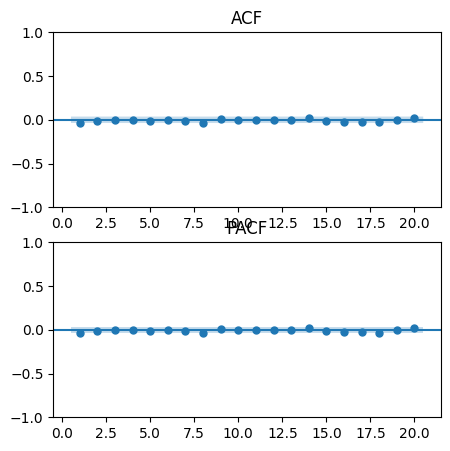

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
plot_acf(data, lags=20, ax=ax1, title='ACF', zero=False)
plot_pacf(data, lags=20, ax=ax2, title='PACF', zero=False)
plt.show()

In [ ]:
# Определяем диапазон p и q (p + q ≤ 5)
p_range = range(0, 6)  # от AR(0) до AR(5)
q_range = range(0, 6)  # от MA(0) до MA(5)

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

for p, q in itertools.product(p_range, q_range):
    if p + q > 5:  # пропускаем, если p + q > 5
        continue

    try:
        model = ARIMA(data, order=(p, 0, q))  # ARMA(p, q) = ARIMA(p, 0, q)
        results = model.fit()

        print(f"ARMA({p},{q}): AIC={results.aic:.2f}, BIC={results.bic:.2f}")

        # Сравниваем AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_model_aic = (p, q)

        # Сравниваем BIC
        if results.bic < best_bic:
            best_bic = results.bic
            best_model_bic = (p, q)

    except Exception as e:
        print(f"ARMA({p},{q}) не сошлась: {e}")
        continue

print("\nЛучшая модель по AIC:", f"ARMA{best_model_aic}")
print("Лучшая модель по BIC:", f"ARMA{best_model_bic}")

ARMA(0,0): AIC=12611.61, BIC=12623.50
ARMA(0,1): AIC=12609.81, BIC=12627.65
ARMA(0,2): AIC=12611.35, BIC=12635.14
ARMA(0,3): AIC=12613.27, BIC=12643.00
ARMA(0,4): AIC=12615.15, BIC=12650.83
ARMA(0,5): AIC=12616.58, BIC=12658.21
ARMA(1,0): AIC=12609.91, BIC=12627.75
ARMA(1,1): AIC=12609.07, BIC=12632.85
ARMA(1,2): AIC=12609.66, BIC=12639.39
ARMA(1,3): AIC=12615.25, BIC=12650.93
ARMA(1,4): AIC=12613.56, BIC=12655.19
ARMA(2,0): AIC=12611.39, BIC=12635.18
ARMA(2,1): AIC=12609.67, BIC=12639.40


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2,2): AIC=12610.98, BIC=12646.66


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2,3): AIC=12612.21, BIC=12653.83
ARMA(3,0): AIC=12613.30, BIC=12643.04
ARMA(3,1): AIC=12615.30, BIC=12650.98


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(3,2): AIC=12612.22, BIC=12653.84
ARMA(4,0): AIC=12615.21, BIC=12650.89
ARMA(4,1): AIC=12617.20, BIC=12658.83
ARMA(5,0): AIC=12616.65, BIC=12658.27

Лучшая модель по AIC: ARMA(1, 1)
Лучшая модель по BIC: ARMA(0, 0)


Анализ автокорреляционной (ACF) и частной автокорреляционной (PACF) функций показывает, что ряд доходностей не содержит статистически значимых лаговых зависимостей, что характерно для процесса, близкого к белому шуму. В связи с этим, а также на основании минимизации информационного критерия BIC, в качестве наилучшей спецификации модели выбрана ARMA(0,0).

In [ ]:
model_arma = ARIMA(data, order=(0, 0, 0))
results_arma = model_arma.fit()

# Остатки модели
residuals = results_arma.resid.dropna()

In [ ]:
alpha = 0.05
jb_test(residuals,alpha)
lb_test(residuals, alpha)
lb_test_squared(residuals, alpha)
arch_test(residuals, alpha)
mcleod_li_test(residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 110130.059, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.0545 
   Лаг  2: p-value = 0.1273 
   Лаг  3: p-value = 0.2425 
   Лаг  4: p-value = 0.3721 
   Лаг  5: p-value = 0.4438 
   Лаг  6: p-value = 0.5693 
   Лаг  7: p-value = 0.5783 
   Лаг  8: p-value = 0.3604 
   Лаг  9: p-value = 0.4046 
   Лаг 10: p-value = 0.4978 
Вывод: Автокорреляция отсутствует

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

Есть ARCH-эффекты (отвергаем H₀ → нужна GARCH-модель)

Тест Энгла (ARCH-LM):

Тест Энгла: Есть ARCH-эффекты (отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 562.3336965108691, p-value: 2.0541629795161582e-114
   Вывод: Обнаружены GARCH-эффекты!


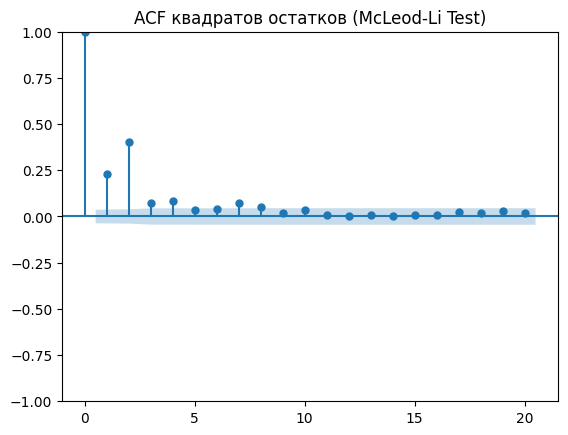

In [ ]:
lags = 20  # Число лагов для анализа
acf_squared = acf(residuals**2, nlags=lags, fft=False)

# Визуализация ACF
plot_acf(residuals**2, lags=lags, alpha=0.05, title='ACF квадратов остатков (McLeod-Li Test)')
plt.show()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 14092.11751911226
Iteration:      2,   Func. Count:     19,   Neg. LLF: 87051.77762958764
Iteration:      3,   Func. Count:     29,   Neg. LLF: 6473.32700924036
Iteration:      4,   Func. Count:     38,   Neg. LLF: 6881.510637352054
Iteration:      5,   Func. Count:     47,   Neg. LLF: 6008.0849763799415
Iteration:      6,   Func. Count:     56,   Neg. LLF: 5830.074640187271
Iteration:      7,   Func. Count:     64,   Neg. LLF: 5766.989163986274
Iteration:      8,   Func. Count:     72,   Neg. LLF: 5788.675142186081
Iteration:      9,   Func. Count:     80,   Neg. LLF: 5786.206928375486
Iteration:     10,   Func. Count:     88,   Neg. LLF: 5748.087572829513
Iteration:     11,   Func. Count:     95,   Neg. LLF: 5748.356049830607
Iteration:     12,   Func. Count:    103,   Neg. LLF: 5747.9095005874115
Iteration:     13,   Func. Count:    110,   Neg. LLF: 5747.8912696082625
Iteration:     14,   Func. Count:    117,   Neg. LLF: 5747.890

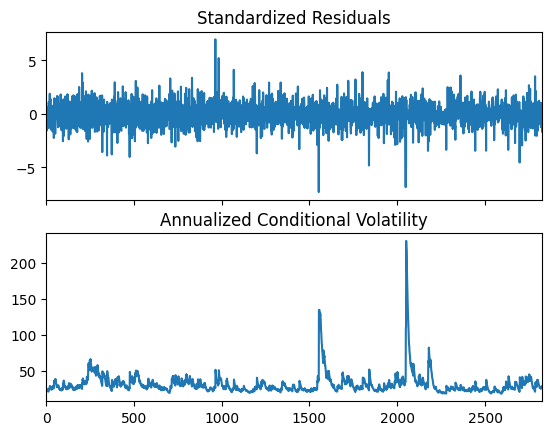

In [ ]:
model_garch = arch_model(residuals, vol="GARCH", p=1, q=1, o=1, dist="ged")
results_garch = model_garch.fit()

# Вывод результатов GARCH
print(results_garch.summary())

# Визуализация волатильности
results_garch.plot(annualize='D')  # Ежедневная волатильность
plt.show()

In [ ]:
std_residuals = results_garch.resid / results_garch.conditional_volatility
std_residuals = std_residuals.dropna()

jb_test(std_residuals,alpha)
lb_test(std_residuals, alpha)
lb_test_squared(std_residuals, alpha)
arch_test(std_residuals, alpha)
mcleod_li_test(std_residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 1832.118, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.5409 
   Лаг  2: p-value = 0.7515 
   Лаг  3: p-value = 0.7951 
   Лаг  4: p-value = 0.9055 
   Лаг  5: p-value = 0.8795 
   Лаг  6: p-value = 0.9007 
   Лаг  7: p-value = 0.9188 
   Лаг  8: p-value = 0.9416 
   Лаг  9: p-value = 0.9150 
   Лаг 10: p-value = 0.9339 
Вывод: Автокорреляция отсутствует

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

Есть ARCH-эффекты (отвергаем H₀ → нужна GARCH-модель)

Тест Энгла (ARCH-LM):

Тест Энгла: Нет ARCH-эффектов (не отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 16.06098414865474, p-value: 0.09789991657725586
   Вывод: GARCH-эффекты отсутствуют


Итого для TATN - ARMA(0,0)-GJR-GARCH(1,1,1)

### Анализ акции NVTK

In [ ]:
data = train_df['NVTK']*100

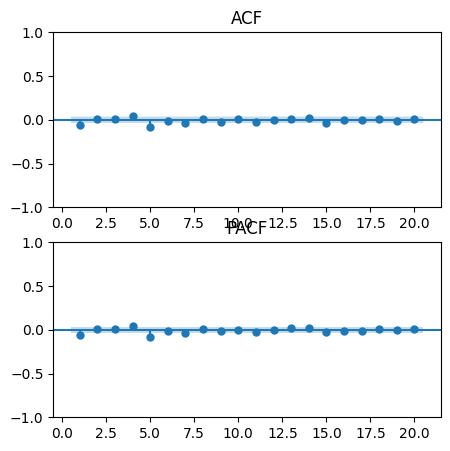

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
plot_acf(data, lags=20, ax=ax1, title='ACF',zero=False)
plot_pacf(data, lags=20, ax=ax2, title='PACF',zero=False)
plt.show()

In [ ]:
# Определяем диапазон p и q (p + q ≤ 5)
p_range = range(0, 6)  # от AR(0) до AR(5)
q_range = range(0, 6)  # от MA(0) до MA(5)

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

for p, q in itertools.product(p_range, q_range):
    if p + q > 5:  # пропускаем, если p + q > 5
        continue

    try:
        model = ARIMA(data, order=(p, 0, q))  # ARMA(p, q) = ARIMA(p, 0, q)
        results = model.fit()

        print(f"ARMA({p},{q}): AIC={results.aic:.2f}, BIC={results.bic:.2f}")

        # Сравниваем AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_model_aic = (p, q)

        # Сравниваем BIC
        if results.bic < best_bic:
            best_bic = results.bic
            best_model_bic = (p, q)

    except Exception as e:
        print(f"ARMA({p},{q}) не сошлась: {e}")
        continue

print("\nЛучшая модель по AIC:", f"ARMA{best_model_aic}")
print("Лучшая модель по BIC:", f"ARMA{best_model_bic}")

ARMA(0,0): AIC=12296.50, BIC=12308.39
ARMA(0,1): AIC=12290.09, BIC=12307.93
ARMA(0,2): AIC=12291.90, BIC=12315.69
ARMA(0,3): AIC=12292.85, BIC=12322.58
ARMA(0,4): AIC=12291.91, BIC=12327.59
ARMA(0,5): AIC=12274.84, BIC=12316.47
ARMA(1,0): AIC=12289.99, BIC=12307.83
ARMA(1,1): AIC=12291.97, BIC=12315.76


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(1,2): AIC=12293.54, BIC=12323.27
ARMA(1,3): AIC=12294.53, BIC=12330.21
ARMA(1,4): AIC=12281.50, BIC=12323.13
ARMA(2,0): AIC=12291.96, BIC=12315.74


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2,1): AIC=12293.74, BIC=12323.48
ARMA(2,2): AIC=12287.61, BIC=12323.29
ARMA(2,3): AIC=12284.87, BIC=12326.50
ARMA(3,0): AIC=12293.37, BIC=12323.10
ARMA(3,1): AIC=12294.93, BIC=12330.61
ARMA(3,2): AIC=12286.39, BIC=12328.02
ARMA(4,0): AIC=12290.53, BIC=12326.21
ARMA(4,1): AIC=12281.07, BIC=12322.70
ARMA(5,0): AIC=12275.56, BIC=12317.18

Лучшая модель по AIC: ARMA(0, 5)
Лучшая модель по BIC: ARMA(1, 0)


In [ ]:
model_arma = ARIMA(data, order=(1, 0, 4))
results_arma = model_arma.fit()

# Остатки модели
residuals = results_arma.resid.dropna()

In [ ]:
alpha = 0.05
jb_test(residuals,alpha)
lb_test(residuals, alpha)
lb_test_squared(residuals, alpha)
arch_test(residuals, alpha)
mcleod_li_test(residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 48772.368, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.9677 
   Лаг  2: p-value = 0.9875 
   Лаг  3: p-value = 0.9988 
   Лаг  4: p-value = 0.9928 
   Лаг  5: p-value = 0.3042 
   Лаг  6: p-value = 0.0757 
   Лаг  7: p-value = 0.1133 
   Лаг  8: p-value = 0.1643 
   Лаг  9: p-value = 0.2282 
   Лаг 10: p-value = 0.2779 
Вывод: Автокорреляция отсутствует

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

Есть ARCH-эффекты (отвергаем H₀ → нужна GARCH-модель)

Тест Энгла (ARCH-LM):

Тест Энгла: Есть ARCH-эффекты (отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 535.4837728906382, p-value: 1.1437802794750716e-108
   Вывод: Обнаружены GARCH-эффекты!


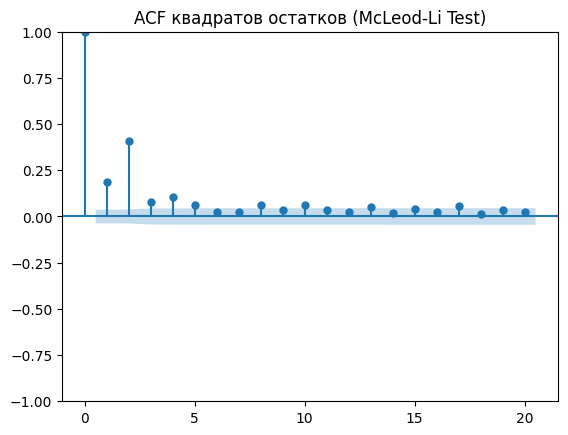

In [ ]:
lags = 20  # Число лагов для анализа
acf_squared = acf(residuals**2, nlags=lags, fft=False)

# Визуализация ACF
plot_acf(residuals**2, lags=lags, alpha=0.05, title='ACF квадратов остатков (McLeod-Li Test)')
plt.show()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 108832027.76132773
Iteration:      2,   Func. Count:     18,   Neg. LLF: 11305846.97712541
Iteration:      3,   Func. Count:     28,   Neg. LLF: 5850.857036475274
Iteration:      4,   Func. Count:     38,   Neg. LLF: 6224.5008353700505
Iteration:      5,   Func. Count:     47,   Neg. LLF: 5743.166292122027
Iteration:      6,   Func. Count:     55,   Neg. LLF: 5775.332731871618
Iteration:      7,   Func. Count:     64,   Neg. LLF: 5670.978518030155
Iteration:      8,   Func. Count:     72,   Neg. LLF: 5688.933465247633
Iteration:      9,   Func. Count:     80,   Neg. LLF: 5638.909739152343
Iteration:     10,   Func. Count:     88,   Neg. LLF: 5648.267099450306
Iteration:     11,   Func. Count:     96,   Neg. LLF: 5628.7984978486875
Iteration:     12,   Func. Count:    103,   Neg. LLF: 5628.673487367073
Iteration:     13,   Func. Count:    110,   Neg. LLF: 5628.665067924192
Iteration:     14,   Func. Count:    117,   Neg. LLF: 5628.66

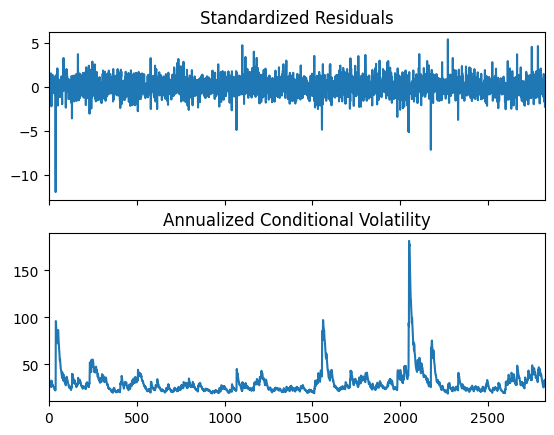

In [ ]:
model_garch = arch_model(residuals, vol="GARCH", p=1, q=1,o=1, dist="ged")
results_garch = model_garch.fit()

# Вывод результатов GARCH
print(results_garch.summary())

# Визуализация волатильности
results_garch.plot(annualize='D')  # Ежедневная волатильность
plt.show()

In [ ]:
std_residuals = results_garch.resid / results_garch.conditional_volatility
std_residuals = std_residuals.dropna()

jb_test(std_residuals,alpha)
lb_test(std_residuals, alpha)
lb_test_squared(std_residuals, alpha)
arch_test(std_residuals, alpha)
mcleod_li_test(std_residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 10138.393, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.4282 
   Лаг  2: p-value = 0.6861 
   Лаг  3: p-value = 0.7900 
   Лаг  4: p-value = 0.8797 
   Лаг  5: p-value = 0.9332 
   Лаг  6: p-value = 0.6650 
   Лаг  7: p-value = 0.7669 
   Лаг  8: p-value = 0.8440 
   Лаг  9: p-value = 0.8579 
   Лаг 10: p-value = 0.8494 
Вывод: Автокорреляция отсутствует

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

ARCH-эффекты отсутствуют (не отвергаем H₀)

Тест Энгла (ARCH-LM):

Тест Энгла: Нет ARCH-эффектов (не отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 2.2466788322186346, p-value: 0.99407602667193
   Вывод: GARCH-эффекты отсутствуют


Итого для NVTK - ARMA(1,4)-GJR-GARCH(1,1,1)

### Анализ акции Index

In [ ]:
data = train_df['Index']*100

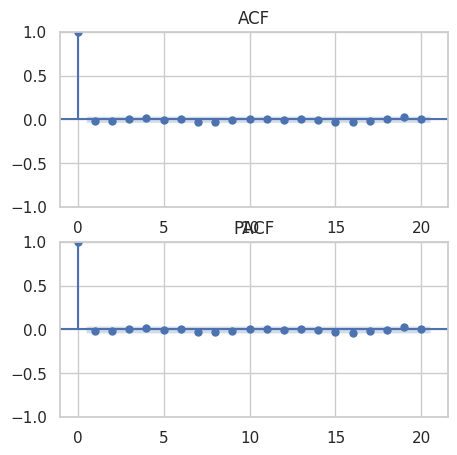

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
plot_acf(data, lags=20, ax=ax1, title='ACF')
plot_pacf(data, lags=20, ax=ax2, title='PACF')
plt.show()

In [ ]:
# Определяем диапазон p и q (p + q ≤ 5)
p_range = range(0, 6)  # от AR(0) до AR(5)
q_range = range(0, 6)  # от MA(0) до MA(5)

best_aic = np.inf
best_bic = np.inf
best_model_aic = None
best_model_bic = None

for p, q in itertools.product(p_range, q_range):
    if p + q > 5:  # пропускаем, если p + q > 5
        continue

    try:
        model = ARIMA(data, order=(p, 0, q))  # ARMA(p, q) = ARIMA(p, 0, q)
        results = model.fit()

        print(f"ARMA({p},{q}): AIC={results.aic:.2f}, BIC={results.bic:.2f}")

        # Сравниваем AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_model_aic = (p, q)

        # Сравниваем BIC
        if results.bic < best_bic:
            best_bic = results.bic
            best_model_bic = (p, q)

    except Exception as e:
        print(f"ARMA({p},{q}) не сошлась: {e}")
        continue

print("\nЛучшая модель по AIC:", f"ARMA{best_model_aic}")
print("Лучшая модель по BIC:", f"ARMA{best_model_bic}")

ARMA(0,0): AIC=11399.21, BIC=11411.10
ARMA(0,1): AIC=11400.61, BIC=11418.45
ARMA(0,2): AIC=11401.72, BIC=11425.51
ARMA(0,3): AIC=11403.63, BIC=11433.37
ARMA(0,4): AIC=11405.02, BIC=11440.70
ARMA(0,5): AIC=11406.94, BIC=11448.56
ARMA(1,0): AIC=11400.63, BIC=11418.47
ARMA(1,1): AIC=11402.23, BIC=11426.02
ARMA(1,2): AIC=11403.70, BIC=11433.43
ARMA(1,3): AIC=11405.72, BIC=11441.40
ARMA(1,4): AIC=11407.63, BIC=11449.26
ARMA(2,0): AIC=11401.68, BIC=11425.47
ARMA(2,1): AIC=11403.65, BIC=11433.39
ARMA(2,2): AIC=11405.39, BIC=11441.07
ARMA(2,3): AIC=11406.87, BIC=11448.50
ARMA(3,0): AIC=11403.61, BIC=11433.35
ARMA(3,1): AIC=11405.61, BIC=11441.29
ARMA(3,2): AIC=11407.39, BIC=11449.02
ARMA(4,0): AIC=11405.07, BIC=11440.75
ARMA(4,1): AIC=11407.07, BIC=11448.70
ARMA(5,0): AIC=11407.01, BIC=11448.64

Лучшая модель по AIC: ARMA(0, 0)
Лучшая модель по BIC: ARMA(0, 0)


In [ ]:
model_arma = ARIMA(data, order=(0, 0, 0))
results_arma = model_arma.fit()

# Остатки модели
residuals = results_arma.resid.dropna()

In [ ]:
alpha = 0.05
jb_test(residuals,alpha)
lb_test(residuals, alpha)
lb_test_squared(residuals, alpha)
arch_test(residuals, alpha)
mcleod_li_test(residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 81992.712, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.4464 
   Лаг  2: p-value = 0.4704 
   Лаг  3: p-value = 0.6616 
   Лаг  4: p-value = 0.7087 
   Лаг  5: p-value = 0.8173 
   Лаг  6: p-value = 0.8960 
   Лаг  7: p-value = 0.7554 
   Лаг  8: p-value = 0.5138 
   Лаг  9: p-value = 0.5658 
   Лаг 10: p-value = 0.6550 
Вывод: Автокорреляция отсутствует

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

Есть ARCH-эффекты (отвергаем H₀ → нужна GARCH-модель)

Тест Энгла (ARCH-LM):

Тест Энгла: Есть ARCH-эффекты (отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 336.16154465669547, p-value: 3.433251161247904e-66
   Вывод: Обнаружены GARCH-эффекты!


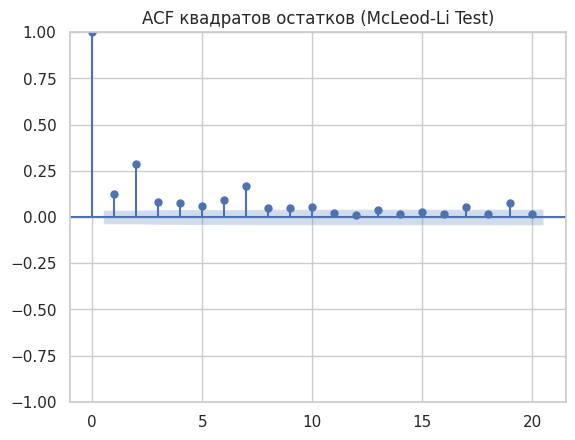

In [ ]:
lags = 20  # Число лагов для анализа
acf_squared = acf(residuals**2, nlags=lags, fft=False)

# Визуализация ACF
plot_acf(residuals**2, lags=lags, alpha=0.05, title='ACF квадратов остатков (McLeod-Li Test)')
plt.show()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 78228.78374944373
Iteration:      2,   Func. Count:     16,   Neg. LLF: 45570.44496626818
Iteration:      3,   Func. Count:     25,   Neg. LLF: 5544.263615595661
Iteration:      4,   Func. Count:     32,   Neg. LLF: 83255.54971963189
Iteration:      5,   Func. Count:     39,   Neg. LLF: 5144.055894087509
Iteration:      6,   Func. Count:     46,   Neg. LLF: 5135.347829340718
Iteration:      7,   Func. Count:     53,   Neg. LLF: 5746.0185992515835
Iteration:      8,   Func. Count:     60,   Neg. LLF: 5259.074485539561
Iteration:      9,   Func. Count:     67,   Neg. LLF: 5114.956442929198
Iteration:     10,   Func. Count:     74,   Neg. LLF: 5100.678868388123
Iteration:     11,   Func. Count:     81,   Neg. LLF: 5098.895467302349
Iteration:     12,   Func. Count:     88,   Neg. LLF: 5098.77653995113
Iteration:     13,   Func. Count:     95,   Neg. LLF: 5098.7698389549905
Iteration:     14,   Func. Count:    101,   Neg. LLF: 5098.7698

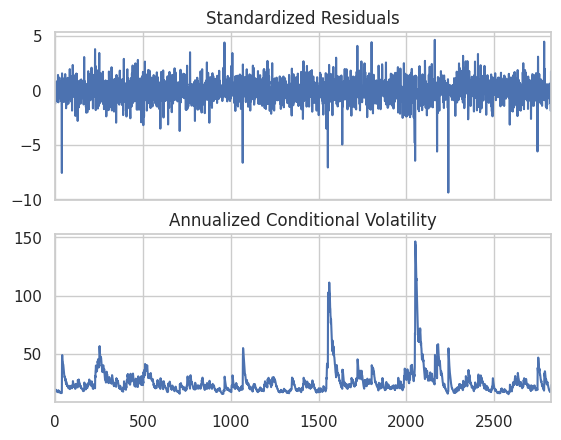

In [ ]:
model_garch = arch_model(residuals, vol="GARCH", p=1, q=1, dist="t")
results_garch = model_garch.fit()

# Вывод результатов GARCH
print(results_garch.summary())

# Визуализация волатильности
results_garch.plot(annualize='D')  # Ежедневная волатильность
plt.show()

In [ ]:
std_residuals = results_garch.resid / results_garch.conditional_volatility
std_residuals = std_residuals.dropna()

jb_test(std_residuals,alpha)
lb_test(std_residuals, alpha)
lb_test_squared(std_residuals, alpha)
arch_test(std_residuals, alpha)
mcleod_li_test(std_residuals, alpha)


1. ТЕСТ НА НОРМАЛЬНОСТЬ (Jarque-Bera):
   Статистика = 6073.335, p-value = 0.0000
   Вывод: Остатки распределены не по нормальному закону!

2. ТЕСТЫ НА АВТОКОРРЕЛЯЦИЮ:

2.1. Лиунг-Бокс (остатки):
   Лаг  1: p-value = 0.0411 *
   Лаг  2: p-value = 0.1044 
   Лаг  3: p-value = 0.2031 
   Лаг  4: p-value = 0.2897 
   Лаг  5: p-value = 0.3788 
   Лаг  6: p-value = 0.4649 
   Лаг  7: p-value = 0.5655 
   Лаг  8: p-value = 0.5536 
   Лаг  9: p-value = 0.6112 
   Лаг 10: p-value = 0.6982 
Вывод: Обнаружена автокорреляция!

ТЕСТЫ НА ГЕТЕРОСКЕДАСТИЧНОСТЬ:

Лиунг-Бокс (квадраты остатков):

ARCH-эффекты отсутствуют (не отвергаем H₀)

Тест Энгла (ARCH-LM):

Тест Энгла: Нет ARCH-эффектов (не отвергаем H₀)

Тест МакЛеода-Ли (McLeod-Li):
LM Statistic: 4.023766411039929, p-value: 0.9462684678169756
   Вывод: GARCH-эффекты отсутствуют


Итого для Index - ARMA(0,0)-GARCH(1,1)